# Table of Contents

* [1. Introduction](#introduction)
* [2. Model Pipeline](#model-pipeline)
* [3. Ceteris Paribus with M-Plot](#mplot)
* [4. Mean Model Response](#mmr)

In [1]:
import matplotlib.pyplot as plt
import numbers
import numpy as np
import pandas as pd
import paralytics as prl
import random
import re
import seaborn as sns
import warnings
import xgboost as xgb

from boruta import BorutaPy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

sns.set_style('ticks')
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 1. Introduction <a class="anchor" id="introduction"></a>

The goal I have chosen is to check what relationship characteristics are conducive to conversion to marriage. Therefore, I have limited myself only to the samples that do not explicitly state they are not in the relationship (variable $S2 == 2$) because therefore those people did not answer a lot of questions about their partners (quite obviously). 

In [2]:
df = pd.read_stata('hcmst_data.dta')

class ColumnNameLowcaser(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame), \
            'Input must be an instance of pandas.DataFrame()!'
        return X.rename(str.lower, axis='columns')

df = ColumnNameLowcaser().fit_transform(df[df.S2.cat.codes != 2])

We have removed samples which for sure were not in marriage so now we can select potentially informative columns and rename every column to its lowercase equivalent. One the first try we will stick to only the most obvious ones in terms of the [documentation](https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf) transparency (very subjective on my part). That's why we will exclude every column containing one of: `refused` or `married` word or time variable because those will require special feature engineering. 

In [3]:
transparent_columns = [
    col for col in df.columns 
    if (
        re.search('^q\d', col)
        or col.startswith(('w6', 'time_', 'hcm2017q24'))
    )
    and not any([
        keyword in col 
        for keyword in ('refused', 'married', 'year', 'month')
    ])
]

transparent_columns.append('age_when_met')

A lot of times no information is an information but this time we will not go into details too much because it will require further investigation on missing values and by removing samples that had no partner at all I would expect to remove most of them. That's why columns with more than 10% of missings will be removed.

In [4]:
y = df.pop('s1').factorize()[0]
X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=SEED 
)

X_train = X_train[transparent_columns].dropna(
    axis='columns',
    thresh=len(X_train) * .9
)

Lastly we can notice that a lot of categorical columns were read this way only due to containing the `Refused` category that is not numeric. We will find those variables and project them onto numeric types while imputing `Refused` category with adequate value.

In [5]:
class RefusedImputer(BaseEstimator, TransformerMixin):
    """Imputes 'Refused' category with np.nan. For columns that should be 
    of numerical type makes projection."""
    def fit(self, X, y=None):
        self.columns_to_convert_ = []
        self.columns_to_project_ = []
        for col in X.columns:
            try:
                col_categories = X[col].cat.categories.tolist()
            except AttributeError as e:
                continue
            if 'Refused' in col_categories:
                self.columns_to_convert_.append(col)
                col_categories.remove('Refused')
                rest_categories_numerical = all([
                    isinstance(cat, numbers.Number)
                    for cat in col_categories
                ])
                if rest_categories_numerical:
                    self.columns_to_project_.append(col)
                    
        return self
    
    def transform(self, X):
        X_new = X.copy()
        for col in self.columns_to_convert_:
            X_new[col] = X_new[col].replace({'Refused': np.nan})
            if col in self.columns_to_project_:
                X_new[col] = X_new[col].astype(float)
            else:
                X_new[col] = X_new[col].astype('category')
        
        return X_new

# Model Pipeline <a class="anchor" id="model-pipeline"></a>

Before we will fit the model, we need to preprocess the data. We will do that in the following steps:

1. Turn every column name into its lowercase equivalent. That will let as select previously chosen columns in the next step.
2. Choose aforementioned columns.
3. Project `Refused` answer onto NaN value.
4. Project binary-like string aswers onto True/ False values.
5. Project column's dtypes onto float/ bool/ category adequately. That is done mainly for the purpose of the next step that selects categorical dtypes and sticks together sparse categories.
6. Group sparse categories.
7. Fit authorial [target/likelihood encoding](https://github.com/mrtovsky/Paralytics/blob/0.2.X/paralytics/encoding.py#L12) to the categorical features. Description can be found under the [link](https://github.com/mrtovsky/Paralytics/blob/0.2.X/paralytics/encoding.py#L13).
8. Impute missings for truely numerical features.
9. Select important features with use of the [Boruta Feature Selection](https://www.jstatsoft.org/article/view/v036i11/v36i11.pdf).
10. Reduce collinearity with use of [Variance Inflation Factor](https://github.com/mrtovsky/Paralytics/blob/0.2.X/paralytics/collinearity_reduction.py#L11).

The only problem is that BorutaPy requires to pass the data as the numpy.array and the [Paralytics package](https://github.com/mrtovsky/Paralytics/tree/0.2.X) on the other hand takes DataFrames as arguments most of the time. To solve this problem we will create a wrapper first. 

In [6]:
class BorutaPyWrapper(BorutaPy):
    def fit(self, X, y):
        try:
            super().fit(X, y)
        except TypeError as e:
            super().fit(X.values, y)
    
    def transform(self, X):
        try:
            X_new = super().transform(X)
        except TypeError as e:
            X_new = super().transform(X.values)
        selected_columns = np.array(X.columns)[self.support_]
        X_new = pd.DataFrame(X_new, columns=selected_columns)
        return X_new

    def fit_transform(self, X, y, weak=False):
        self.fit(X, y)
        return self.transform(X)

Now we can process to fitting our model.

In [7]:
selected_columns = X_train.columns.tolist()

KEYWORDS_TRUE = [
    'yes',
    'YES',
    'Yes',
    'Yes, we are a same-sex couple',
    'Yes, I am Married',
    'Yes, I have a sexual partner'
]

KEYWORDS_FALSE = [
    'no',
    'NO',
    'No',
    'No, we are an opposite-sex couple',
    'No, I am not Married'
]
rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)

xgb_model_pipeline = make_pipeline(
    ColumnNameLowcaser(),
    prl.preprocessing.ColumnSelector(columns=selected_columns),
    RefusedImputer(),
    prl.preprocessing.CategoricalBinarizer(
        keywords_true=KEYWORDS_TRUE, keywords_false=KEYWORDS_FALSE
    ),
    prl.preprocessing.ColumnProjector(),
    prl.preprocessing.CategoricalGrouper(new_cat='OtherCategory'),
    prl.TargetEncoder(cv=5, inner_cv=3, alpha=5, random_state=SEED),
    prl.preprocessing.Imputer(numerical_method='median'),
    BorutaPyWrapper(
        rf, n_estimators='auto', verbose=2,
        max_iter=150, random_state=SEED
    ),
    prl.VIFSelector(thresh=5., impute=False, verbose=1),
    xgb.XGBClassifier()
)

We will be filtering RuntimeWarning for stylistic purposes because the warning is raised by the `BorutaPy` object. This problem is not an issue (except stylistics obviously) and was fixed in this [pull request](https://github.com/scikit-learn-contrib/boruta_py/pull/35) but it's still not included in the package itself. 

In [8]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    xgb_model_pipeline.fit(X_train, y_train)

Iteration: 	1 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	2 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	3 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	4 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	5 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	6 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	7 / 150
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	8 / 150
Confirmed: 	27
Tentative: 	10
Rejected: 	66
Iteration: 	9 / 150
Confirmed: 	27
Tentative: 	10
Rejected: 	66
Iteration: 	10 / 150
Confirmed: 	27
Tentative: 	10
Rejected: 	66
Iteration: 	11 / 150
Confirmed: 	27
Tentative: 	10
Rejected: 	66
Iteration: 	12 / 150
Confirmed: 	27
Tentative: 	6
Rejected: 	70
Iteration: 	13 / 150
Confirmed: 	27
Tentative: 	6
Rejected: 	70
Iteration: 	14 / 150
Confirmed: 	27
Tentative: 	6
Rejected: 	70
Iteration: 	15 / 150
Confirmed: 	27
Tentative: 	6
Rejected: 	70
Iteration: 	16 / 150
Confirmed: 	27
Tentative

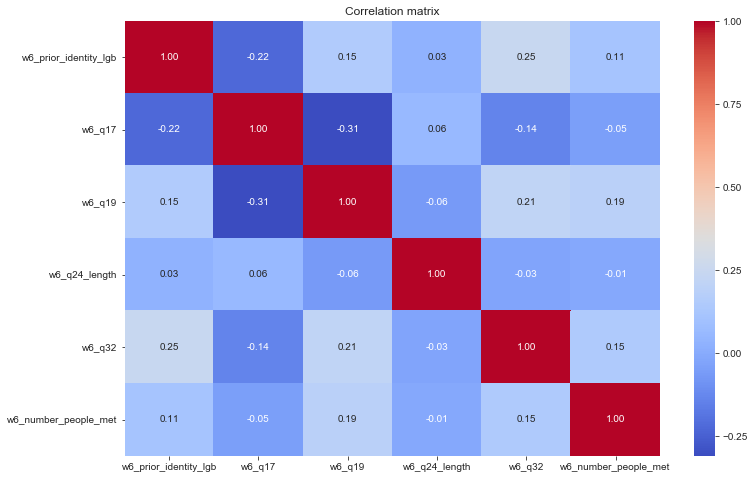

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

X_train_transformed = Pipeline(
    xgb_model_pipeline.steps[:-1]
).transform(X_train)

ax = sns.heatmap(
    X_train_transformed.corr(), annot=True, fmt=".2f", 
    cmap="coolwarm", ax=ax
)
ax.set_title('Correlation matrix')
plt.show()

In [16]:
importances = (
    xgb_model_pipeline.named_steps['xgbclassifier']
    .feature_importances_
)

selected_features = (
    xgb_model_pipeline.named_steps['vifselector'].kept_cols_
)

feat_importance_pairs = list(zip(selected_features, importances))
feat_importance_pairs.sort(key=lambda x: x[1], reverse=True)

for feature, importance in feat_importance_pairs:
    print(
        'Variable "{0}" importance is equal to: {1:.2f}'
        .format(feature, importance)
    )

Variable "w6_q24_length" importance is equal to: 0.34
Variable "w6_q32" importance is equal to: 0.21
Variable "w6_q17" importance is equal to: 0.18
Variable "w6_q19" importance is equal to: 0.14
Variable "w6_prior_identity_lgb" importance is equal to: 0.11
Variable "w6_number_people_met" importance is equal to: 0.02


Accuracy is not the best metric to this problem because there is a bit unbalanced response variable but we will stick to the basics because performance of the model is not the main target.

In [11]:
from sklearn.metrics import accuracy_score


y_guessed = [0] * len(y_test)
y_pred = xgb_model_pipeline.predict(X_test)

print(
    'Model accuracy is equal to: {0:.2f}%. '
    'It can be benchmarked with a \nprediction that every '
    'sample is belonging to the majority class. \nIf so then the '
    'benchmark accuracy is: {1:.2f}%.'
    .format(
        accuracy_score(y_test, y_pred) * 100,
        accuracy_score(y_test, y_guessed) * 100
    )
)

Model accuracy is equal to: 92.32%. It can be benchmarked with a 
prediction that every sample is belonging to the majority class. 
If so then the benchmark accuracy is: 71.94%.


# Ceteris Paribus with M-Plot <a class="anchor" id="mplot"></a>

In [13]:
class DependencyPainter(object):
    def __init__(self, model, grid):
        self.model = model
        self.grid = grid
    
    def fit(self, X, sample_size, random_state=None):
        X_sample = X.sample(sample_size, random_state=random_state).copy()
        
        unique_grid_values = X[self.grid].unique().tolist()
        original_values = X[self.grid]
        synthetic_dfs = [
            X_sample.assign(**{
                'TrueGridValue': original_values, 
                'ID': X_sample.index, 
                self.grid: grid_value
            })
            for grid_value in unique_grid_values
        ]
        X_synthetic = pd.concat(synthetic_dfs, ignore_index=True, sort=False)
        
        y_pred = self.model.predict_proba(X_synthetic.drop(['ID', 'TrueGridValue'], axis=1))[:, 1]
        self.df_synthetic_grid_ = X_synthetic[['ID', self.grid, 'TrueGridValue']].assign(Prediction=y_pred)
        
        return self

    def calculate_average_sample(self, scope=None):
        if not hasattr(self, 'df_synthetic_grid_'):
            raise RuntimeError('You need to fit the data first')
        if scope is None:
            df_average_sample = self.df_synthetic_grid_.groupby(self.grid).agg(
                {'Prediction': 'mean'}
            ).reset_index()
        else:
            df_average_sample = self.df_synthetic_grid_[
                np.abs(self.df_synthetic_grid_['TrueGridValue'] - self.df_synthetic_grid_[self.grid]) <= scope
            ].groupby(self.grid).agg({'Prediction': 'mean'}).reset_index()
        
        return df_average_sample

    def plot(self, color, scope=None):
        if not hasattr(self, 'df_synthetic_grid_'):
            raise RuntimeError('You need to fit the data first')
        fig, ax = plt.subplots()
        ax = sns.lineplot(
             x=self.grid, y='Prediction', hue='ID', estimator=None, 
            data=self.df_synthetic_grid_, legend=False, ax=ax
        )
        avg_guy = self.calculate_average_sample(scope)
        for line in ax.lines:
            line.set_color(color)
    
        ax = ax.plot(avg_guy[self.grid], avg_guy['Prediction'], color='r', linewidth=5)
        
        return ax    

We have plotted 300 ceteris paribus profiles for randomly selected samples with the thickened red M-plot line distinguished. Scopes were selected based on magnitudes of the variables analyzed. For example:
* Scope equal to 100 means that our M-plot will be fed with only those predictions which corresponding synthetic feature value is distant by no more than 100 units from the real observed value for the given sample.

Just to confirm, I will say that we model the probability of not being married. That's why the first plot that is illustrating the potential predictive power of the variable `w6_q17` what stands for: "times subject was married" shows that if somebody has never been married then the probability of not being married is equal to 1 and if somebody has been married at least once, then the probability of not being married at present is really low.

The second variable `w6_q24_length` (length of the answer on how partners got to know each other) is pretty unstable but when the answer was long enough then we can believe that the person is married. It can be caused by insufficient number of samples and this instability should be a cause of concern.

The most interesting conclusions can be observed by analyzing the last plot were ceteris paribus profiles show that the variable is meaningless. By only drawing the M-plot we can clearly detect change of the interpretability of the same variable. It is interesting that we do not observe the slope on any of the ceteris paribus profiles and even though we can see a big slope in the M-plot. That is intriguing until we see the unique values of this numeric but better interpreted as an ordinal feature. Tt could be expected from the lack of smooth transitions between the M-plot line components.

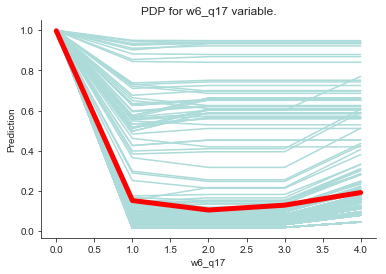

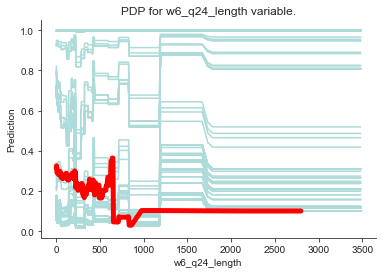

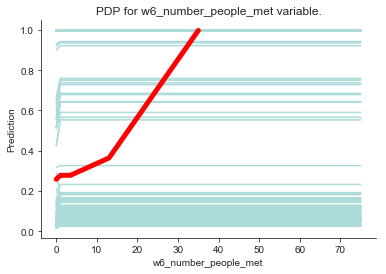

In [14]:
features = ['w6_q17', 'w6_q24_length', 'w6_number_people_met']
scopes = [1, 100, 5]

for col, scope in zip(features, scopes):
    painter = DependencyPainter(xgb_model_pipeline, col)

    painter.fit(X_train, 300, random_state=SEED)

    ax = painter.plot('#ACDBD9', scope)

    plt.title('PDP for {} variable.'.format(col))
    sns.despine()
    plt.show()

In [15]:
print('Count unique values of the `w6_number_people_met` variable.')
df.w6_number_people_met.value_counts()

Count unique values of the `w6_number_people_met` variable.


0.0     2604
1.0      107
3.5       85
13.0      25
35.0       6
75.0       1
Name: w6_number_people_met, dtype: int64

The interesting number 3.5 is caused by the definition of this variable that is probably the mean value of 2 other variables that say something about the number of meetings.

## Mean Model Response <a class="anchor" id="mmr"></a>

Class ConditionalResponder will help us demonstrate the effects of adding on variables in specified order.

In [43]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart

from collections import OrderedDict


class ConditionalResponder(object):
    def __init__(self, model, benchmark):
        self.model = model
        self.benchmark = benchmark

    @property
    def benchmark(self):
        return self._benchmark

    @benchmark.setter
    def benchmark(self, sample):
        try:
            _benchmark = sample.squeeze()
            assert isinstance(_benchmark, pd.Series), \
                'Benchmark sample can contain only a single record.'
            self._benchmark = _benchmark.to_dict()
        except AttributeError:
            if not isinstance(sample, (dict, OrderedDict)):
                raise TypeError(
                    'Cannot accept object in type {} specified as the '
                    'benchmark.'.format(type(sample))
                ) from None
            self._benchmark = sample

    def fit(self, X, features, ordered=0):
        self.benchmark_prediction_ = np.mean(
            self.model.predict_proba(X)[:, 1])
        
        if ordered:
            self.response_ = self._calculate_ordered_response(
                X, features)
        else:
            self.response_ = self._calculate_mean_response(
                X, features)
        
        return self

    def plot(self):
        if not hasattr(self, 'response_'):
            raise RuntimeError(
                'Could not find the attribute.\nFitting is necessary before '
                'you do the transformation!'
            )
        keys = ['benchmark'] + list(self.response_.keys())
        values = [self.benchmark_prediction_] + list(self.response_.values())
        ax = waterfall_chart.plot(
            keys, values, rotation_value=60, formatting="{:,.2f}"
        )
        sns.despine()

        return ax

    def _calculate_mean_response(self, X, features, verbose=0):
        prediction_deltas = pd.DataFrame(columns=features)
        
        for permutation in itertools.permutations(features, len(features)):
            prediction_delta = self._calculate_ordered_response(X, permutation)
            prediction_deltas = prediction_deltas.append(
                pd.Series(prediction_delta), ignore_index=True
            )
        
        prediction_mean_delta = prediction_deltas.agg(
            'mean', axis='index'
        ).squeeze().to_dict()

        return prediction_mean_delta

    def _calculate_ordered_response(self, X, features, verbose=0):
        predictions = []
        predictions.append(np.mean(self.model.predict_proba(X)[:, 1]))
        df_synthetic = X.copy()

        for idx, feature in enumerate(features):
            if verbose:
                print(
                    'Calculating mean model response for the No. {} '
                    'feature: "{}"'.format(idx, feature)
                )
            df_synthetic.loc[:, feature] = self.benchmark[feature]
            predictions.append(
                np.mean(self.model.predict_proba(df_synthetic)[:, 1])
            )

        prediction_delta = OrderedDict(zip(features, np.diff(predictions).tolist()))

        return prediction_delta


In [44]:
benchmark_observation = X_train.sample(1, random_state=SEED)

# Show only features that will be included in the final prediction
benchmark_observation[selected_features]

,w6_prior_identity_lgb,w6_q17,w6_q19,w6_q24_length,w6_q32,w6_number_people_met
2529,straight/ non LGB,1.0,Yes,149.0,"No, I did NOT meet [Partner Name] through the ...",0.0


Our benchmark prediction will be a person that is:
* "straight" (slightly controversial answer added by the authors of the survey - just my thought), 
* has been once married, 
* is currently living with the partner,
* length of the answer to the question about the first meeting is equal to 149 characters,
* did not use the internet services to meet a partner,
* did not meet anyone in the past year for the dating romance or sex and excluding from counting the current partner did not meet anybody in the past year.

Let's check whether he / she is married.

In [45]:
benchmark_married = bool(abs((y_train[X_train.index == benchmark_observation.index[0]][0] - 1)))
print('Is he / she married? The answer is: {}.'.format(benchmark_married))

Is he / she married? The answer is: True.


Our labels are opposite than intuition would suggest and if somebody is married then he has "0" label assigned. We will keep this in mind.

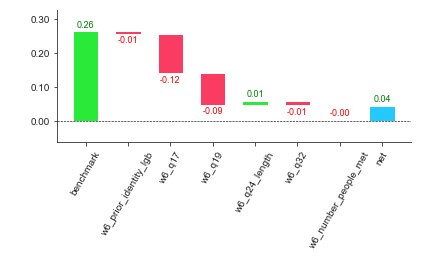

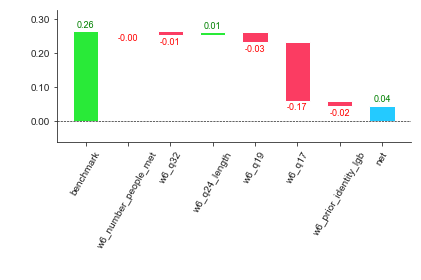

In [50]:
responder = ConditionalResponder(xgb_model_pipeline, benchmark_observation)

responder.fit(X_train, selected_features, ordered=1)
responder.plot()
plt.show()

responder.fit(X_train, selected_features[::-1], ordered=1)
responder.plot()
plt.show()

First of all we can clearly see that our model is doing a good job in classifying the sample properly (assigning proba = 96% of being married to the person that is labeled as married). Secondly, it is worth mentioning that the model on the average assigns lower probabilities (average 0.26 of not being married). This is due to the observed imbalance in the dataset (that's why accuracy is not the best metric for this problem).

**Now let's focus on the homework**. We can see that including our features in the both sides does not change a lot in the delta probability which remain without significant changes. This may indicate that there are no major interactions between selected variables.

However, we observe the intuitive influence of variables on prediction:

1. If a person does not identify themselves as LGBT, then the chance of being married increases slightly.
2. If a person was married once, then the chances are that he/she is still married and has a (possible) happy relationship (happy enough that he/she has not broken yet).
3. If he lives with a partner, it is also a big chance that the relationship is more serious - marriage. *Probability of not being married keeps decreasing.*
4. Being laconic in words (only 149 used to describe the first meeting with the love of your life) suggests little love for the partner / lack of commitment, hence the probability of not being married slightly increases.
5. Not using the internet to meet the second half cements the relationship.
6. This one is only surprising that the model did not take into consideration (what we already knew from the previous Ceteris Paribus profiles) number of people that the person was meeting in the last year. It would seem that a small number of dates (in our case 0) may suggest that someone has already stopped looking for love, but there is probably enough information hidden in the variables already discussed.
